[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/mapelites.ipynb)

# JEDi: Quality with Just Enough Diversity

This notebook shows how to use QDax to find diverse and performing controllers in MDPs with [MAP-Elites](https://arxiv.org/abs/1504.04909).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process
- how to save/load a repertoire

In [1]:
#@title Installs and Imports
# !pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

try:
    import brax
except:
    # !pip install git+https://github.com/google/brax.git@v0.0.15 |tail -n 1
    import brax

try:
    import qdax
except:
    # !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax


from qdax.core.map_elites import MAPElites
from qdax.core.custom_repertoire_mapelites import CustomMAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.containers.count_repertoire import CountMapElitesRepertoire, count_qd_metrics

from qdax import environments
from qdax.tasks.brax_envs import scoring_function_brax_envs as scoring_function
from qdax.tasks.brax_envs import reset_based_scoring_function_brax_envs

from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results

from qdax.utils.metrics import CSVLogger, default_qd_metrics

from jax.flatten_util import ravel_pytree

from IPython.display import HTML
from brax.io import html



if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()


clear_output()

%matplotlib inline

In [2]:
def net_shape(net):
    return jax.tree_map(lambda x: x.shape, net)

In [3]:
#@title QD Training Definitions Fields
#@markdown ---
batch_size = 100 #@param {type:"number"}
env_name = 'pointmaze' #@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
# env_name = 'pointmaze'#@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 1000 #@param {type:"integer"}
num_iterations = 1000 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.05 #@param {type:"number"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
# num_centroids = 8192 #@param {type:"integer"}
min_bd = 0.0 #@param {type:"number"}
max_bd = 1.0 #@param {type:"number"}
#@markdown ---

In [4]:
plot_maze = False
if env_name == "pointmaze":
    min_bd = -1.0
    episode_length = 100
    plot_maze = True

if env_name == "antmaze":
    min_bd, max_bd = [-5, 40]
    episode_length = 250
    plot_maze = False

In [5]:
robert = False
if robert:
    policy_hidden_layer_sizes = (32,) * 4
    activation = jnp.tanh
else:
    policy_hidden_layer_sizes = (64, 64)
    activation = jax.nn.relu

print(policy_hidden_layer_sizes)

(64, 64)


## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [6]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
    activation=activation,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)


# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

## Define the way the policy interacts with the env

Now that the environment and policy has been defined, it is necessary to define a function that describes how the policy must be used to interact with the environment and to store transition data.

In [7]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [8]:
# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
# metrics_function = functools.partial(
#     default_qd_metrics,
#     qd_offset=reward_offset * episode_length,
# )
metrics_function = functools.partial(
    count_qd_metrics,
    qd_offset=reward_offset * episode_length,
)


## Define the emitter

The emitter is used to evolve the population at each mutation step.

In [9]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    variation_fn=variation_fn, 
    variation_percentage=1.0, 
    batch_size=batch_size
)

## Instantiate and initialise the MAP Elites algorithm

In [10]:
# Instantiate MAP-Elites
map_elites = CustomMAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
    repertoire_type=CountMapElitesRepertoire,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)

# Compute initial repertoire and emitter state
init_repertoire, emitter_state, random_key = map_elites.init(init_variables, centroids, random_key)
repertoire = init_repertoire

/home/paul/Dev/QDax/qdax/core/custom_repertoire_mapelites.py:67: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = self.repertoire_type.init(


In [11]:
init_metrics = metrics_function(init_repertoire)
list(init_metrics.keys())

['qd_score',
 'max_fitness',
 'coverage',
 'min_count',
 'max_count',
 'mean_count',
 'median_count',
 'std_count']

## Launch MAP-Elites iterations

In [12]:
log_period = 50
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=["loop", "iteration", "time"] + list(init_metrics.keys()),
)
all_metrics = {}
repertoire = init_repertoire

from tqdm import tqdm
# main loop
map_elites_scan_update = map_elites.scan_update
for i in tqdm(range(num_loops)):
    start_time = time.time()
    # main iterations
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse, "loop": 1+i, "iteration": 1 + i*log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

    csv_logger.log(logged_metrics)

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


In [13]:
end_repertoire = repertoire

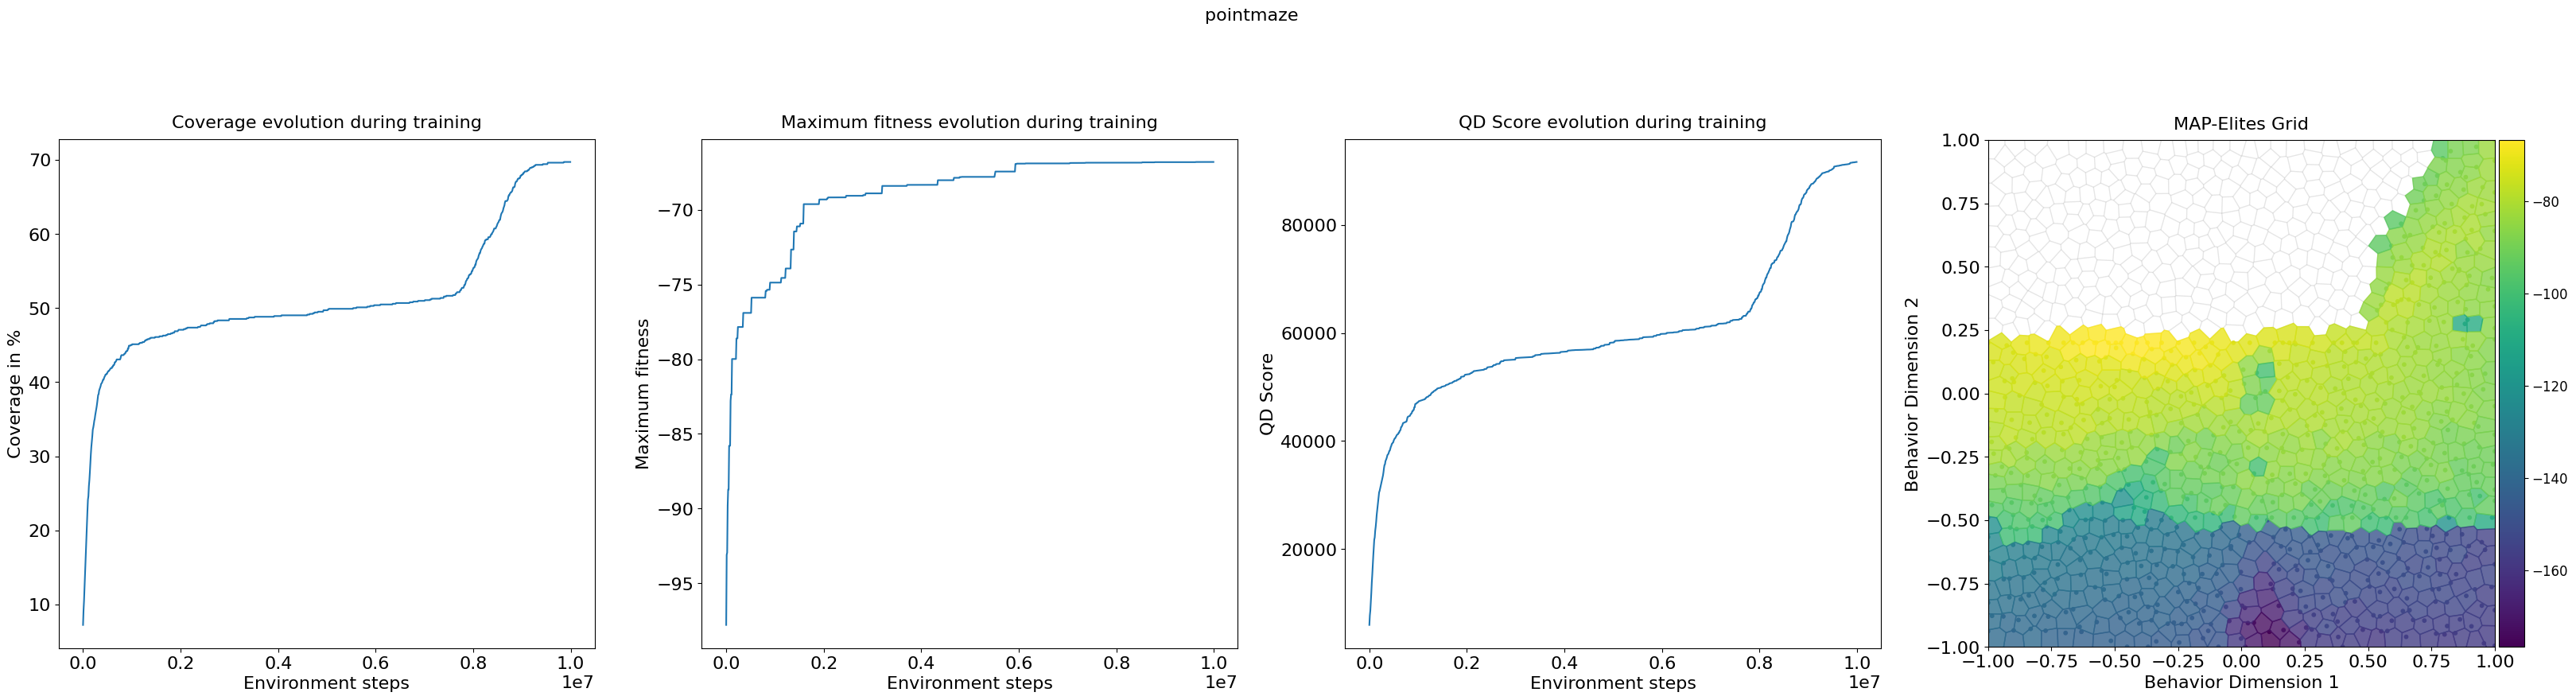

In [15]:
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length * batch_size

# create the plots and the grid
import matplotlib.pyplot as plt
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=all_metrics, repertoire=end_repertoire, min_bd=min_bd, max_bd=max_bd)
# general title
fig.suptitle(env_name, fontsize=16);
# plt.title(env_name)

In [18]:
fig.savefig(f"plots/ME_{env_name}_{episode_length}_{num_centroids}.png", dpi=300, bbox_inches="tight")

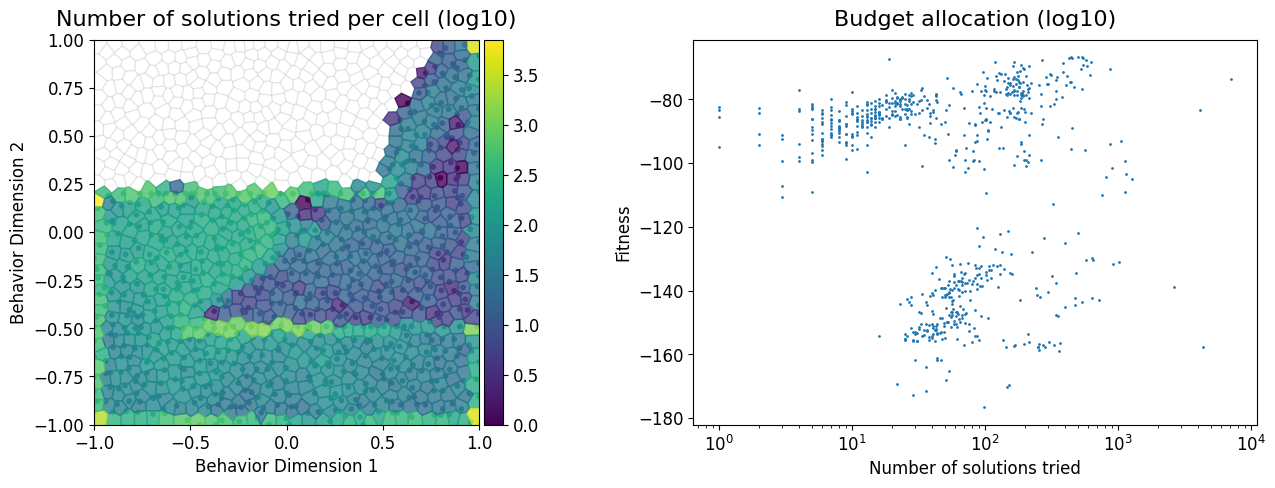

In [18]:
from qdax.jedi.plotting import plot_2d_count, scatter_count
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0] = plot_2d_count(end_repertoire, min_bd, max_bd, log_scale=True, ax=axes[0])
axes[1] = scatter_count(end_repertoire, log_scale=True, ax=axes[1])

In [19]:
end_repertoire.fitnesses.max()

Array(-66.78294, dtype=float32)

## Gaussian process

In [20]:
import gpjax as gpx

In [21]:
# Enable Float64 for more stable matrix inversions.
from jax.config import config

config.update("jax_enable_x64", True)
import jax
from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
# from docs.examples.utils import clean_legend

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.PRNGKey(123)
# plt.style.use("./gpjax.mplstyle")
# cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# make all plots size 5x10
# mpl.rcParams["figure.figsize"] = (10, 5)

In [22]:
# Summarize this section into a function that takes a repertoire and returns a GP
# Add a function for 2d plotting

# import partial
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

def fit_GP(repertoire, num_iters=1000):
    """Fit a GP to a repertoire."""
    random_key = jax.random.PRNGKey(0)
    # Remove empty points
    is_empty = repertoire.fitnesses == -jnp.inf
    bd = repertoire.centroids[~is_empty]
    fitness = repertoire.fitnesses[~is_empty]

    D = gpx.Dataset(X=bd, y=fitness.reshape(-1, 1))

    # Prior
    # prior_constant = jnp.max(fitness)
    prior_constant = jnp.mean(fitness)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Constant(prior_constant)
    prior = gpx.Prior(mean_function=meanf, kernel=kernel)

    # Posterior
    likelihood = gpx.Gaussian(num_datapoints=D.n)

    posterior = prior * likelihood

    # Parameter state
    negative_mll = gpx.objectives.ConjugateMLL(negative=True)
    negative_mll(posterior, train_data=D)

    negative_mll = jit(negative_mll)

    # Optimization

    opt_posterior, history = gpx.fit(
        model=posterior,
        objective=negative_mll,
        train_data=D,
        optim=ox.adam(learning_rate=0.01),
        num_iters=num_iters,
        safe=True,
        key=key,
    )

    return opt_posterior, D

def add_maze(ax):
    # Outside walls
    ax.plot([-1, -1], [-1, 1], color="k")
    ax.plot([1, 1], [-1, 1], color="k")
    ax.plot([-1, 1], [-1, -1], color="k")
    ax.plot([-1, 1], [1, 1], color="k")

    circle_x = -1 + 0.5
    circle_y = 1 - 0.2
    circle_width = 0.1
    wall_width_ratio = 0.75
    upper_wall_height_offset = 0.2
    lower_wall_height_offset = -0.5

    wall_width = 2 * wall_width_ratio
    # lower wall
    ax.plot(
        [-1 + wall_width/2, 1],
        [lower_wall_height_offset, lower_wall_height_offset],
        color="k",
    )

    # upper wall
    ax.plot(
        [-1, 1 - wall_width/2],
        [upper_wall_height_offset, upper_wall_height_offset],
        color="k",
    )

    circle = plt.Circle((circle_x, circle_y), circle_width/2, color='g', fill=True, label="Target")
    ax.add_artist(circle)
    return ax


def plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=False, min_bd=-1, max_bd=1):
    """Plot a GP on a grid."""
    # Remove empty points
    is_empty = repertoire.fitnesses == -jnp.inf
    bd = repertoire.centroids[~is_empty]
    fitness = repertoire.fitnesses[~is_empty]

    D = gpx.Dataset(X=bd, y=fitness.reshape(-1, 1))

    # plot contour on larger grid
    min_bd = min_bd - 0.5 if larger else min_bd
    max_bd = max_bd + 0.5 if larger else max_bd
    x1 = jnp.linspace(min_bd, max_bd, grid_size)
    x2 = jnp.linspace(min_bd, max_bd, grid_size)
    X1, X2 = jnp.meshgrid(x1, x2)
    X_grid = jnp.vstack([X1.ravel(), X2.ravel()]).T

    latent_dist = opt_posterior.predict(X_grid, train_data=D)
    predictive_dist = opt_posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    # plot contour
    fig, ax = plt.subplots(figsize=(5, 5))
    im = plt.contourf(X1, X2, predictive_mean.reshape(grid_size, grid_size), cmap="coolwarm")
    plt.scatter(bd[:, 0], bd[:, 1], c=fitness, cmap="viridis", s=1)
    if maze:
        ax = add_maze(ax)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Fitness')

    # plt.title("Mean")

    if plot_std:
        # plot contour
        fig, std_ax = plt.subplots(figsize=(5, 5))
        plt.contourf(X1, X2, predictive_std.reshape(grid_size, grid_size), cmap="coolwarm")
        plt.colorbar()
        plt.scatter(bd[:, 0], bd[:, 1], c=fitness, cmap="viridis", s=1)
        if maze:
            std_ax = add_maze(std_ax)
        plt.title("Std")
        ax = [ax, std_ax]
    
    return ax

    # plot contour
    # fig, ax = plt.subplots(figsize=(5, 5))
    # plt.contourf(X1, X2, (predictive_mean + predictive_std).reshape(grid_size, grid_size), cmap="coolwarm")
    # plt.colorbar()
    # plt.scatter(bd[:, 0], bd[:, 1], c=fitness, cmap="viridis", s=1)
    # plt.title("Mean + Std")

/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

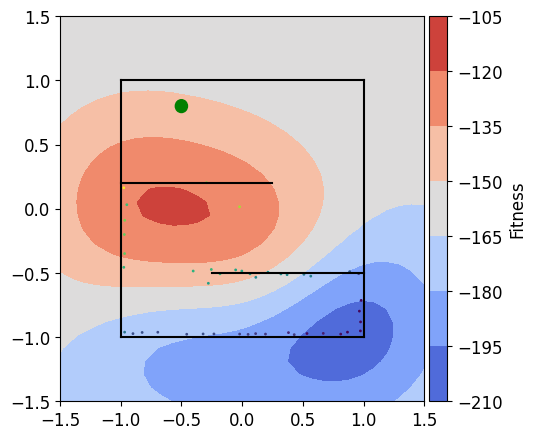

In [23]:
repertoire = init_repertoire
opt_posterior, D = fit_GP(repertoire, num_iters=1000)

plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=add_maze, min_bd=-1, max_bd=1)

## BD selection
### Pareto front
- Pareto front on mean and std
    - Mean: resample potentially good solutions
    - Std: sample zones not explored yet

In [24]:
# Pareto front
def pareto_front(points, f1, f2):
    def is_dominated(x):
        """Check if a point is dominated."""
        return jnp.any((f1 > x[0]) & (f2 > x[1]))
    # zip f1 and f2
    f = jnp.vstack([f1, f2]).T
    dominated = jax.vmap(is_dominated)(f)
    return points[~dominated]

def get_pareto(points, opt_posterior, train_data, bounds, n_points=100, plot=False, return_front=False):
    points = points.astype(jnp.float64)
    rng = jax.random.PRNGKey(0)
    # minval = jnp.array([bounds[0][0], bounds[1][0]])
    # maxval = jnp.array([bounds[0][1], bounds[1][1]])

    # Evaluate the points with the GP
    latent_dist = opt_posterior.predict(points, train_data=train_data)
    predictive_dist = opt_posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        # scatter mean vs std
        plt.scatter(predictive_mean, predictive_std, color="b", s=5, label="Points")
        plt.xlabel("Mean")
        plt.ylabel("Std")
        plt.title("Mean vs Std")

    # Pareto front
    indices = jnp.arange(len(points))
    pf_indices = pareto_front(indices, predictive_mean, predictive_std)

    # Sample from the Pareto front
    if len(pf_indices) > n_points:
        selected_indices = jax.random.choice(rng, pf_indices, shape=(n_points,), replace=False)
    elif len(pf_indices) == n_points:
        selected_indices = pf_indices
    else:
        # Complete with random other points
        n_random = n_points - len(pf_indices)
        # randomly select indices
        random_indices = jax.random.choice(rng, indices, shape=(n_random,), replace=False)
        print(pf_indices.shape, random_indices.shape)
        # concatenate 
        selected_indices = jnp.vstack([pf_indices.reshape(-1, 1), random_indices.reshape(-1, 1)]).reshape(-1)
        # selected_indices = jnp.vstack([pf_indices, random_indices])
        print(selected_indices.shape)
        
    if plot:
        # plot pareto front
        pareto_mean = predictive_mean[pf_indices]
        pareto_std = predictive_std[pf_indices]
        ax.scatter(pareto_mean, pareto_std, color="g", s=5, label="Pareto front")
        selected_mean = predictive_mean[selected_indices]
        selected_std = predictive_std[selected_indices]
        ax.scatter(selected_mean, selected_std, color="r", s=5, label="Selected points")
        ax.legend()

    if return_front:
        # print("Returning pareto front")
        if len(pf_indices) < n_points:
            # Complete with random other points
            n_random = n_points - len(pf_indices)
            # randomly select indices
            random_indices = jax.random.choice(rng, indices, shape=(n_random,), replace=False)
            print(pf_indices.shape, random_indices.shape)
            # concatenate 
            selected_indices = jnp.vstack([pf_indices.reshape(-1, 1), random_indices.reshape(-1, 1)]).reshape(-1)
        else:
            selected_indices = pf_indices
        return points[selected_indices]

    pf_points = points[selected_indices].astype(jnp.float32)
    return pf_points
    
def random_pareto(opt_posterior, train_data, bounds, n_points=100, n_samples=1000, plot=False, return_front=False):
    rng = jax.random.PRNGKey(0)
    minval = jnp.array([bounds[0][0], bounds[1][0]])
    maxval = jnp.array([bounds[0][1], bounds[1][1]])
    points = jax.random.uniform(rng, (n_samples, 2), minval=minval, maxval=maxval)
    return get_pareto(points, opt_posterior, train_data, bounds, n_points=n_points, plot=plot, return_front=return_front)

def centroids_pareto(repertoire, opt_posterior, train_data, bounds, n_points=100, plot=False, return_front=False):
    return get_pareto(repertoire.centroids, opt_posterior, train_data, bounds, n_points=n_points, plot=plot, return_front=return_front)
        
def archive_pareto(repertoire, opt_posterior, train_data, bounds, n_points=100, plot=False, return_front=False):
    is_empty = repertoire.fitnesses == -jnp.inf
    archive = repertoire.centroids[~is_empty]
    return get_pareto(archive, opt_posterior, train_data, bounds, n_points=n_points, plot=plot, return_front=return_front)

### Descriptor crowding

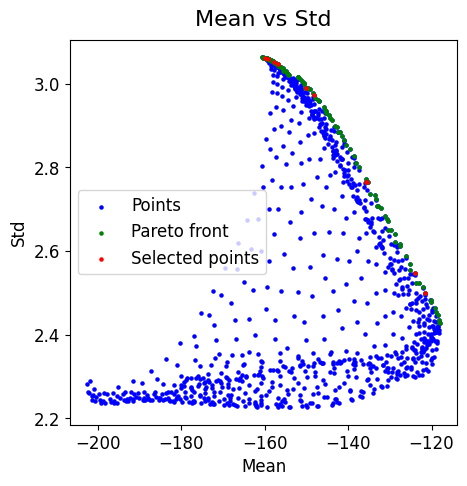

In [25]:
bounds = [[min_bd, max_bd]] * 2
front = centroids_pareto(repertoire, opt_posterior, D, bounds, n_points=10, plot=True, return_front=True)

/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


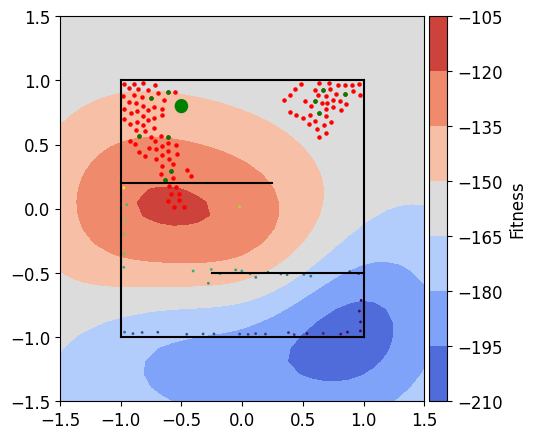

In [26]:
# fig, ax = plt.subplots(figsize=(5, 5))
# Get 10 random points of the Pareto front
rng = jax.random.PRNGKey(0)
selected = jax.random.choice(rng, front.shape[0], shape=(10,), replace=False)

ax = plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=add_maze, min_bd=-1, max_bd=1)
ax.scatter(front[:, 0], front[:, 1], color="r", s=5, label="Pareto front")
ax.scatter(front[selected, 0], front[selected, 1], color="g", s=5, label="Random points")

In [27]:
# Compute pair-wise distances
def dist(x1, x2):
    return jnp.sqrt(jnp.sum((x1 - x2) ** 2))

def dist_matrix(points):
    # Compute the distance matrix using vmap
    return jax.vmap(lambda x: jax.vmap(lambda y: dist(x, y))(points))(points)

d = dist_matrix(front)
d.shape

(113, 113)

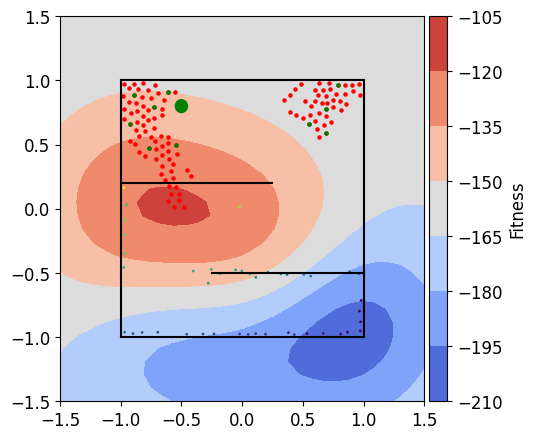

In [28]:
# shuffle front
rng = jax.random.PRNGKey(0)
shuffled = jax.random.permutation(rng, front)
# Compute the distance matrix
d = dist_matrix(shuffled)
# Only get the upper triangular part
d = jnp.triu(d, k=1)
# Min per line
d = jnp.min(d, axis=1)
# Get top 10 points
top_indices = jnp.argsort(d)[:10]
top_points = front[top_indices]

# fig, ax = plt.subplots(figsize=(5, 5))
ax = plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=add_maze, min_bd=-1, max_bd=1)
ax.scatter(front[:, 0], front[:, 1], color="r", s=5, label="Pareto front")
ax.scatter(top_points[:, 0], top_points[:, 1], color="g", s=5, label="Top points")

In [29]:
# Compute pair-wise distances
def dist(x1, x2):
    return jnp.sqrt(jnp.sum((x1 - x2) ** 2))

def dist_matrix(points):
    # Compute the distance matrix using vmap
    return jax.vmap(lambda x: jax.vmap(lambda y: dist(x, y))(points))(points)

# Crowded wrapper
def crowded(func):
    def wrapped(*args, **kwargs):
        # print("Wow it's crowded in here")
        kwargs["return_front"]=True
        front = func(*args, **kwargs)
        # shuffle front
        rng = jax.random.PRNGKey(0)
        shuffled = jax.random.permutation(rng, front)
        # Compute the distance matrix
        d = dist_matrix(shuffled)
        # Only get the upper triangular part
        d = jnp.triu(d, k=1)
        # Replace 0 with inf
        d = jnp.where(d == 0, jnp.inf, d)
        # Min per line
        d = jnp.min(d, axis=1)
        # print(d)
        # Get top 10 points
        top_indices = jnp.argsort(d)[:kwargs["n_points"]]
        top_points = front[top_indices]
        return top_points
    return wrapped

crowded_centroids_pareto = crowded(centroids_pareto)
crowded_archive_pareto = crowded(archive_pareto)


# def crowded_centroids_pareto(repertoire, opt_posterior, train_data, bounds, n_points=100, plot=False):
#     front = get_pareto(repertoire.centroids, opt_posterior, train_data, bounds, n_points=n_points, plot=plot, return_front=True)
#     # shuffle front
#     rng = jax.random.PRNGKey(0)
#     shuffled = jax.random.permutation(rng, front)
#     # Compute the distance matrix
#     d = dist_matrix(shuffled)
#     # Only get the upper triangular part
#     d = jnp.triu(d, k=1)
#     # Min per line
#     d = jnp.min(d, axis=1)
#     # Get top 10 points
#     top_indices = jnp.argsort(d)[:n_points]
#     top_points = front[top_indices]
#     return top_points

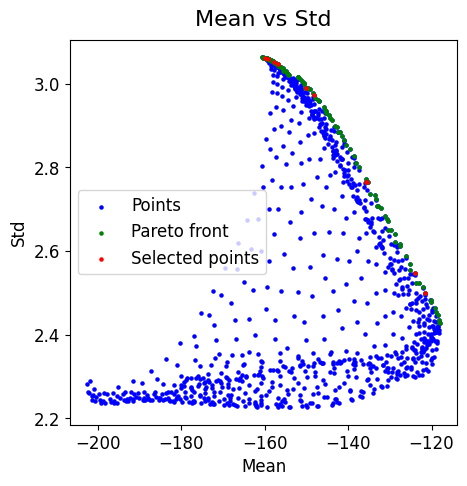

In [30]:
bounds = [[min_bd, max_bd]] * 2
targets = crowded_centroids_pareto(repertoire, opt_posterior, D, bounds, n_points=10, plot=True, return_front=False)

In [31]:
targets.shape

(10, 2)

### GP-UCB

In [32]:
def gp_ucb(repertoire, opt_posterior, train_data, beta, bounds, n_points=100, plot=False):
    points = repertoire.centroids.astype(jnp.float64)
    # rng = jax.random.PRNGKey(0)

    # Evaluate the points with the GP
    latent_dist = opt_posterior.predict(points, train_data=train_data)
    predictive_dist = opt_posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    # Normalize with mean
    predictive_mean = predictive_mean - predictive_mean.mean()
    predictive_std = predictive_dist.stddev()

    ucb = predictive_mean + jnp.sqrt(beta) * predictive_std
    # top n_points indices
    argmax_ucb = jnp.argsort(ucb)[-n_points:]
    selected_points = points[argmax_ucb].astype(jnp.float32)

    return selected_points

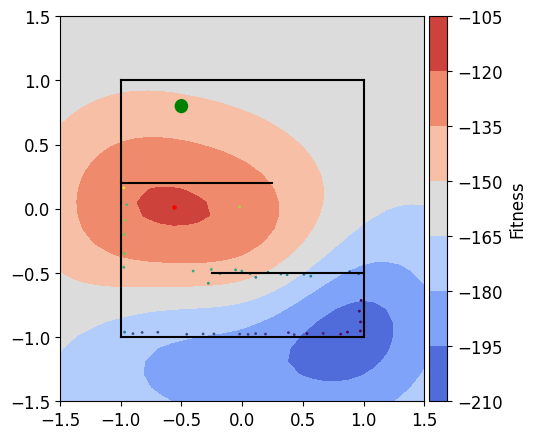

In [33]:
bounds = [[min_bd, max_bd]] * 2
ucb_beta = 1
targets = gp_ucb(repertoire, opt_posterior, D, ucb_beta, bounds, n_points=1, plot=True)

ax = plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=add_maze, min_bd=-1, max_bd=1)
# Scatter targets
ax.scatter(targets[:, 0], targets[:, 1], color="r", s=5, label="Targets")

## Evolution Strategies

In [34]:
from qdax.tasks.brax_envs import (
    make_policy_network_play_step_fn_brax,
    reset_based_scoring_function_brax_envs,
)
from qdax.core.rl_es_parts.canonical_es import CanonicalESConfig, CanonicalESEmitter


class BaseES:
    def __init__(self, env, config):
        self.config = config
        self.random_key = jax.random.PRNGKey(0)

        self.env = env

    def init(self, policy_network):

        random_key, subkey = jax.random.split(self.random_key)
        keys = jax.random.split(subkey, num=1)
        fake_batch = jnp.zeros(shape=(1, self.env.observation_size))
        init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

        play_reset_fn = self.env.reset

        # Prepare the scoring function
        bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]

        play_step_fn = make_policy_network_play_step_fn_brax(self.env, policy_network)

        self.es_scoring_fn = functools.partial(
            reset_based_scoring_function_brax_envs,
            episode_length=episode_length,
            play_reset_fn=play_reset_fn,
            play_step_fn=play_step_fn,
            behavior_descriptor_extractor=bd_extraction_fn,
        )

        es_config = CanonicalESConfig(
            nses_emitter=False,
            sample_number=self.config["sample_number"],
            canonical_mu=int(self.config["sample_number"] / 2),
            sample_sigma=self.config["sigma"],
            actor_injection=False,
            nb_injections=0,
            episode_length=episode_length,
            return_population=True,
        )

        self.emitter = CanonicalESEmitter(
            config=es_config,
            rollout_fn=self.es_scoring_fn,
            eval_fn=self.es_scoring_fn,
            total_generations=self.config["es_gens"],
            num_descriptors=env.behavior_descriptor_length,
        )

        es_emitter_state, random_key = self.emitter.init(
            init_genotypes=init_variables,
            random_key=random_key,
        )
        return es_emitter_state, random_key

    def scan_step(self, carry, unused):
        raise NotImplementedError
        
    def step(self, start, target_bd, es_emitter_state, random_key, n_steps=1):
        (offspring, target_bd, es_emitter_state, random_key), metrics = jax.lax.scan(
            self.scan_step,
            (start, target_bd, es_emitter_state, random_key),
            None,
            length=n_steps,
        )
        # Remove the batch dimension
        metrics = jax.tree_map(lambda x: x.squeeze(), metrics)
        return offspring, metrics, es_emitter_state, random_key
    
    def evaluate(self, genotype, random_key):
        offspring_fitnesses, offspring_descriptors, extra_scores, random_key = self.emitter._rollout_fn(
                genotype,
                random_key
            )
        return offspring_fitnesses, offspring_descriptors, extra_scores, random_key
        

class BD_ES(BaseES):
    def scan_step(self, carry, unused):
        start, target_bd, es_emitter_state, random_key = carry
        @jax.jit
        def bd_scores_fn(fitnesses, descriptors) -> jnp.ndarray:
            # minimize distance to target_bd
            return  - jnp.linalg.norm(descriptors - target_bd, axis=1)

        offspring, optimizer_state, random_key, extra_scores = self.emitter._es_emitter(
            parent = start,
            random_key = random_key,
            scores_fn = bd_scores_fn,
            optimizer_state=es_emitter_state.optimizer_state
        )
        # evaluate offspring
        offspring_fitnesses, offspring_descriptors, offspring_extra_scores, random_key = self.emitter._rollout_fn(
            offspring,
            random_key
        )

        metrics = {
            "genotype": offspring,
            "fitness": offspring_fitnesses,
            "descriptor": offspring_descriptors,
            "population_fitness": extra_scores["population_fitness"],
            "population_descriptors": extra_scores["population_descriptors"],
            "population_networks": extra_scores["population_networks"],
        }

        es_emitter_state = es_emitter_state.replace(
            optimizer_state=optimizer_state
        )

        return (offspring, target_bd, es_emitter_state, random_key), metrics

/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [35]:
class Fitness_ES(BaseES):
    def scan_step(self, carry, unused):
        start, target_bd, es_emitter_state, random_key = carry
        @jax.jit
        def bd_scores_fn(fitnesses, descriptors) -> jnp.ndarray:
            # minimize distance to target_bd
            return  fitnesses

        offspring, optimizer_state, random_key, extra_scores = self.emitter._es_emitter(
            parent = start,
            random_key = random_key,
            scores_fn = bd_scores_fn,
            optimizer_state=es_emitter_state.optimizer_state
        )
        # evaluate offspring
        offspring_fitnesses, offspring_descriptors, offspring_extra_scores, random_key = self.emitter._rollout_fn(
            offspring,
            random_key
        )

        metrics = {
            "genotype": offspring,
            "fitness": offspring_fitnesses,
            "descriptor": offspring_descriptors,
            "population_fitness": extra_scores["population_fitness"],
            "population_descriptors": extra_scores["population_descriptors"],
            "population_networks": extra_scores["population_networks"],
        }

        es_emitter_state = es_emitter_state.replace(
            optimizer_state=optimizer_state
        )

        return (offspring, target_bd, es_emitter_state, random_key), metrics
        

In [36]:
class MixedES(BaseES):
    def step(self, repertoire, start, target_bd, es_emitter_state, random_key, n_steps=1):
        (centroids, offspring, target_bd, es_emitter_state, random_key), metrics = jax.lax.scan(
            self.scan_step,
            (repertoire.centroids, start, target_bd, es_emitter_state, random_key),
            None,
            length=n_steps,
        )
        # Remove the batch dimension
        metrics = jax.tree_map(lambda x: x.squeeze(), metrics)
        return offspring, metrics, es_emitter_state, random_key


    def scan_step(self, carry, unused):
        centroids, start, target_bd, es_emitter_state, random_key = carry

        @jax.jit
        def bd_scores_fn(fitnesses, descriptors) -> jnp.ndarray:
            # Get index of target_bd in repertoire
            target_idx = jnp.argmin(jnp.linalg.norm(centroids - target_bd, axis=-1))
            # Compute distance from descriptors to repertoire
            centroids_dists = jnp.linalg.norm(descriptors[:, None, :] - centroids[None, :, :], axis=-1)
            # Get argmin for each descriptor
            bd_index = jnp.argmin(centroids_dists, axis=-1)
            # Compute distance of each descriptor to target_bd
            dists = jnp.linalg.norm(descriptors - target_bd, axis=-1)
            fmin = jnp.min(fitnesses)
            # Score: fitnesses if argmin is target_idx, distance to target_bd otherwise
            scores = jnp.where(bd_index == target_idx, fitnesses, fmin-dists)
            return  scores

        offspring, optimizer_state, random_key, extra_scores = self.emitter._es_emitter(
            parent = start,
            random_key = random_key,
            scores_fn = bd_scores_fn,
            optimizer_state=es_emitter_state.optimizer_state
        )
        # evaluate offspring
        offspring_fitnesses, offspring_descriptors, offspring_extra_scores, random_key = self.emitter._rollout_fn(
            offspring,
            random_key
        )

        metrics = {
            "genotype": offspring,
            "fitness": offspring_fitnesses,
            "descriptor": offspring_descriptors,
            "population_fitness": extra_scores["population_fitness"],
            "population_descriptors": extra_scores["population_descriptors"],
            "population_networks": extra_scores["population_networks"],
        }

        es_emitter_state = es_emitter_state.replace(
            optimizer_state=optimizer_state
        )

        return (centroids, offspring, target_bd, es_emitter_state, random_key), metrics

### Get starting point

In [37]:
from jax.tree_util import tree_flatten, tree_unflatten, tree_map

# def dist(d):
#     return - jnp.linalg.norm(d - target_bd)

def closest_genotype(repertoire, target_bd):
    is_empty = repertoire.fitnesses == -jnp.inf
    useful_centroids = repertoire.centroids[~is_empty]
    indices = jnp.arange(len(repertoire.centroids))[~is_empty]

    # get closes centroid to target_bd
    distances = jnp.linalg.norm(useful_centroids - target_bd, axis=1)
    cent_idx = distances.argmin()
    start_bd = useful_centroids[cent_idx]
    start_genome = tree_map(lambda x: x[indices[cent_idx]], repertoire.genotypes)

    return start_genome, start_bd

def stochastic_closest(repertoire, target_bd, top_n=5):
    pass

# Main algo loop

In [38]:
def aim_for(target, repertoire, es, config, base_es_emitter_state, random_key):
    target = jnp.array(target).astype(jnp.float32)
    # Select closest genotype in repertoire
    start, start_bd = closest_genotype(repertoire, target)
    # add a dimension
    start = jax.tree_map(
        lambda x: x[None, ...],
        start,
    )
    # print(net_shape(start))

    # Run ES
    if isinstance(es, MixedES):
        final_offspring, metrics, es_emitter_state, random_key = es.step(
            repertoire,
            start,
            target,
            base_es_emitter_state,
            random_key,
            n_steps=config["es_gens"],
        )
    else:
        final_offspring, metrics, es_emitter_state, random_key = es.step(
            start,
            target,
            base_es_emitter_state,
            random_key,
            n_steps=config["es_gens"],
        )
    return metrics, es_emitter_state, random_key

In [48]:
reward_offset

2.3431

Logging initial archive
Not doing actor injection
layer_shapes [(32,), (2, 32), (32,), (32, 32), (32,), (32, 32), (32,), (32, 32), (2,), (32, 2)]
sizes [  32   64   32 1024   32 1024   32 1024    2   64]
layer_sizes [32, 64, 32, 1024, 32, 1024, 32, 1024, 2, 64]
split_indices [32, 96, 128, 1152, 1184, 2208, 2240, 3264, 3266]
Not doing actor injection
layer_shapes [(32,), (2, 32), (32,), (32, 32), (32,), (32, 32), (32,), (32, 32), (2,), (32, 2)]
sizes [  32   64   32 1024   32 1024   32 1024    2   64]
layer_sizes [32, 64, 32, 1024, 32, 1024, 32, 1024, 2, 64]
split_indices [32, 96, 128, 1152, 1184, 2208, 2240, 3264, 3266]
Fitting GP...


/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

Exploration ES


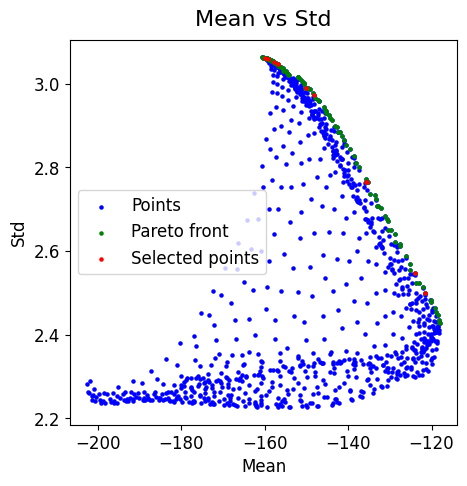

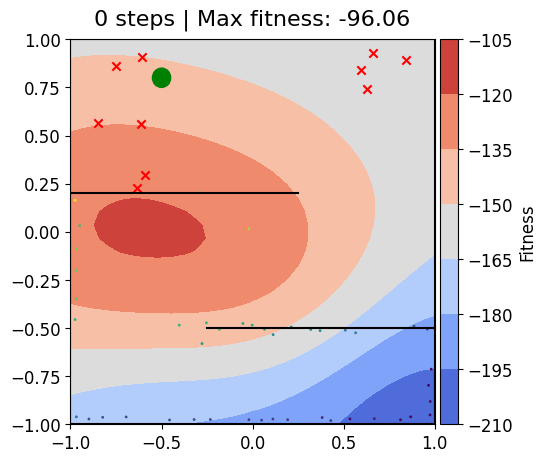

ES time: 28.25s
Max fitness: -29.516419793738418
Adding new genotypes to repertoire
Logging results
Fitting GP...


  0%|          | 0/1000 [00:00<?, ?it/s]

Exploitation ES
(9,) (1,)
(10,)


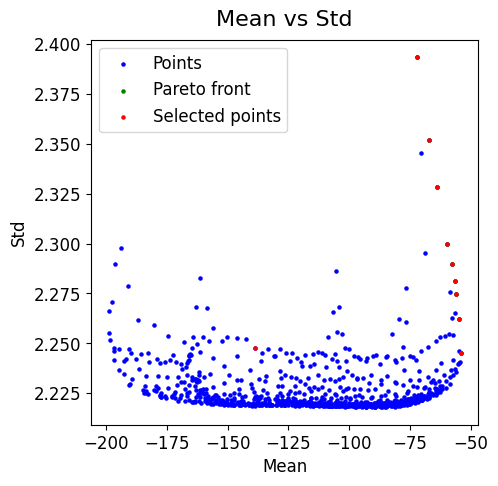

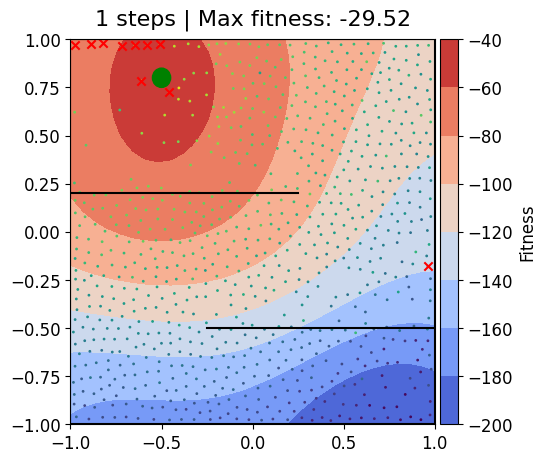

ES time: 27.74s
Max fitness: -22.74749115694718
Adding new genotypes to repertoire
Logging results
Fitting final GP


  0%|          | 0/1000 [00:00<?, ?it/s]

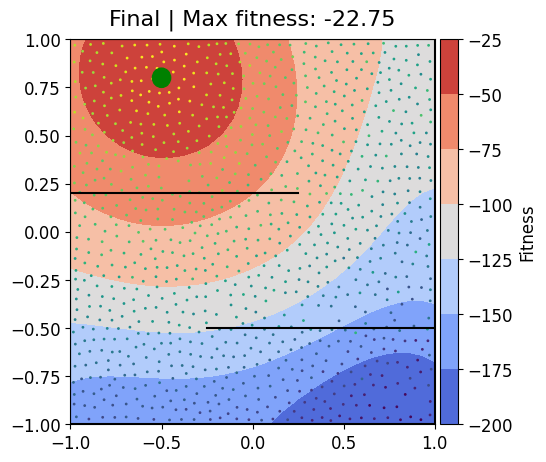

In [57]:
from time import time

# Algo loop
bounds = [[min_bd, max_bd]] * 2
qd_offset = reward_offset * episode_length
macro_loops = 2
target_nb = 10
larger = False
mixed = False
crowding = False

config = {
    "sample_number" : 10,
    "sigma" : 0.1, 
    "es_gens" : 1000,
}

random_key = jax.random.PRNGKey(0)

# Init repertoire
repertoire = init_repertoire

print("Logging initial archive")
loop = 0
logs = {
    "steps": [],
    "evaluations": [],
    "frames" : [],
    "max_fitness": [],
    "coverage": [],
    "qd_score": []
}
repertoire_empty = repertoire.fitnesses == -jnp.inf
initial_evals = sum(~repertoire_empty)

logs["steps"].append(loop)
evals = loop * target_nb * config["es_gens"] * (config["sample_number"]) + initial_evals
logs["evaluations"].append(evals)
logs["frames"].append(evals * episode_length)

qd_score = jnp.sum(repertoire.fitnesses, where=~repertoire_empty)
logs["qd_score"].append(qd_score + reward_offset * jnp.sum(1.0 - repertoire_empty))
logs["coverage"].append(100 * jnp.mean(1.0 - repertoire_empty))
logs["max_fitness"].append(jnp.max(repertoire.fitnesses))

# ES
if mixed:
    bd_es = MixedES(env, config)
else:
    bd_es = BD_ES(env, config)
base_bd_es_emitter_state, base_random_key = bd_es.init(policy_network)

fit_es = Fitness_ES(env, config)
base_fit_es_emitter_state, base_random_key = fit_es.init(policy_network)

explor_pareto = centroids_pareto
exploit_pareto = archive_pareto

if crowding:
    explor_pareto = crowded(explor_pareto)
    exploit_pareto = crowded(exploit_pareto)


for loop in range(1, macro_loops + 1):
    max_fitness = jnp.max(repertoire.fitnesses)
    # Fit GP to repertoire
    print("Fitting GP...")
    opt_posterior, train_data = fit_GP(repertoire)
    # print("Done.")

    # Sample BD targets
    # target_bd = random_pareto(
    #     opt_posterior,
    #     train_data,
    #     bounds,
    #     n_points=target_nb, 
    #     n_samples=1000
    # )

    if loop % 2:
        print("Exploration ES")
        es = bd_es
        base_es_emitter_state = base_bd_es_emitter_state
        target_bd = explor_pareto(
            repertoire, 
            opt_posterior, 
            train_data, 
            bounds, 
            n_points=target_nb,
            plot=True
            )

    else:
        print("Exploitation ES")
        es = fit_es
        base_es_emitter_state = base_fit_es_emitter_state
        target_bd = exploit_pareto(
            repertoire, 
            opt_posterior, 
            train_data, 
            bounds, 
            n_points=target_nb,
            plot=True
            )

    # print(f"Targets: {target_bd}")
    # Scatter targets
    ax = plot_GP(repertoire, opt_posterior, grid_size=30, larger=larger, maze=plot_maze, min_bd=min_bd, max_bd=max_bd)
    ax.scatter(target_bd[:, 0], target_bd[:, 1], c="r", marker="x")
    ax.set_title(f"{loop-1} steps | Max fitness: {max_fitness:.2f}")
    plt.show()

    # vmap on targets
    t0 = time()
    metrics, es_emitter_state, random_key = jax.vmap(
        lambda target: aim_for(
            target,
            repertoire,
            es,
            config,
            base_es_emitter_state,
            random_key,
    ))(target_bd)
    print(f"ES time: {time() - t0:.2f}s")

    random_key = random_key[0]
    
    fitnesses = metrics["population_fitness"].reshape(-1)
    descriptors = metrics["population_descriptors"].reshape(-1, 2)
    genotypes = metrics["population_networks"]
     # Concatenate on first 2 dimensions
    genotypes = jax.tree_map(
        lambda x: x.reshape(-1, *x.shape[3:]),
        genotypes
    )
    # shapes
    # print("Pop Shapes")
    # print(fitnesses.shape)
    # print(descriptors.shape)
    # print(net_shape(genotypes))

    # # reshape metrics (-1, 2)*
    # fitnesses = metrics["fitness"].reshape(-1)
    # descriptors = metrics["descriptor"].reshape(-1, 2)
    # genotypes = metrics["genotype"]

    # # Concatenate on first 2 dimensions
    # genotypes = jax.tree_map(
    #     lambda x: x.reshape(-1, *x.shape[2:]),
    #     genotypes
    # )

    # print("Center Shapes")
    # print(fitnesses.shape)
    # print(descriptors.shape)
    # print(net_shape(genotypes))
    

    print(f"Max fitness: {fitnesses.max()}")
    # print(net_shape(genotypes))

    # # Add new genotypes to repertoire
    print("Adding new genotypes to repertoire")
    repertoire = repertoire.add(genotypes, descriptors, fitnesses)

    # Log
    print("Logging results")
    logs["steps"].append(loop)
    evals = loop * target_nb * config["es_gens"] * (config["sample_number"])
    logs["evaluations"].append(evals)
    logs["frames"].append(evals * episode_length)

    repertoire_empty = repertoire.fitnesses == -jnp.inf
    qd_score = jnp.sum(repertoire.fitnesses, where=~repertoire_empty)
    logs["qd_score"].append(qd_score + qd_offset * jnp.sum(1.0 - repertoire_empty))
    logs["coverage"].append(100 * jnp.mean(1.0 - repertoire_empty))
    logs["max_fitness"].append(jnp.max(repertoire.fitnesses))
        
print("Fitting final GP")
opt_posterior, train_data = fit_GP(repertoire)
ax = plot_GP(repertoire, opt_posterior, grid_size=30, larger=larger, maze=plot_maze, min_bd=min_bd, max_bd=max_bd)
max_fitness = jnp.max(repertoire.fitnesses)
ax.set_title(f"Final | Max fitness: {max_fitness:.2f}")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

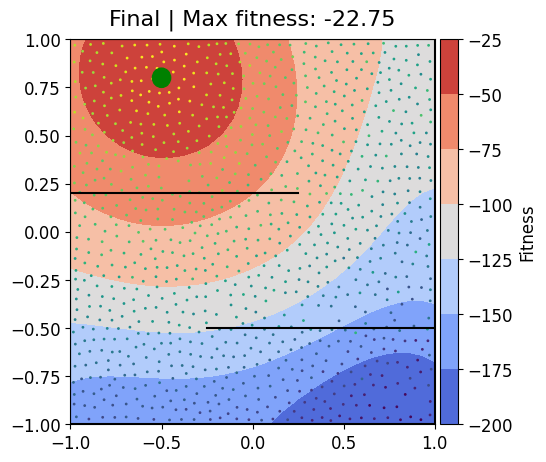

In [58]:
opt_posterior, train_data = fit_GP(repertoire)
ax = plot_GP(repertoire, opt_posterior, grid_size=30, larger=larger, maze=plot_maze, min_bd=min_bd, max_bd=max_bd)
max_fitness = jnp.max(repertoire.fitnesses)
ax.set_title(f"Final | Max fitness: {max_fitness:.2f}")
plt.show()

(None, <Axes: xlabel='Behavior Dimension 1', ylabel='Behavior Dimension 2'>)

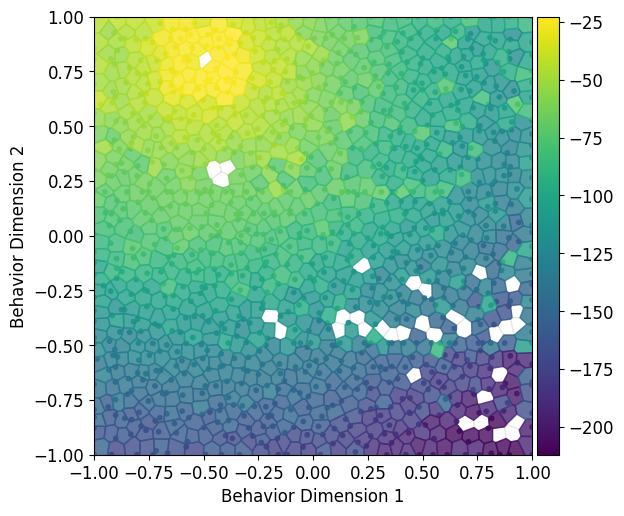

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_2d_map_elites_repertoire(
    centroids=repertoire.centroids,
    repertoire_fitnesses=repertoire.fitnesses,
    minval=min_bd,
    maxval=max_bd,
    repertoire_descriptors=repertoire.descriptors,
    ax=ax,
    title="",
)

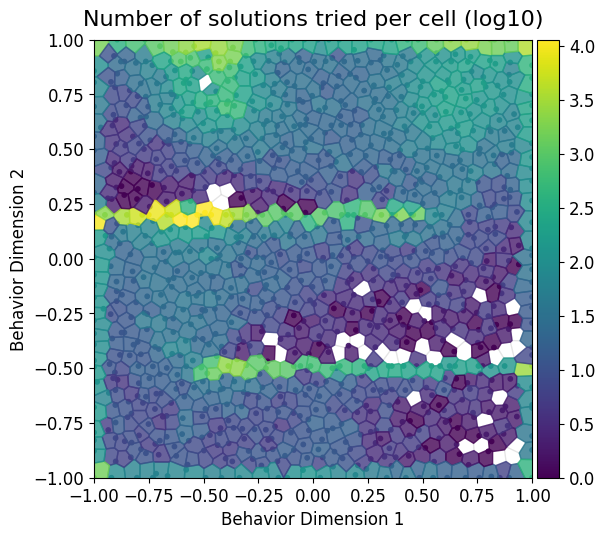

In [60]:
ax = plot_2d_count(repertoire, min_bd, max_bd, log_scale=True)

Text(0, 0.5, 'Fitness')

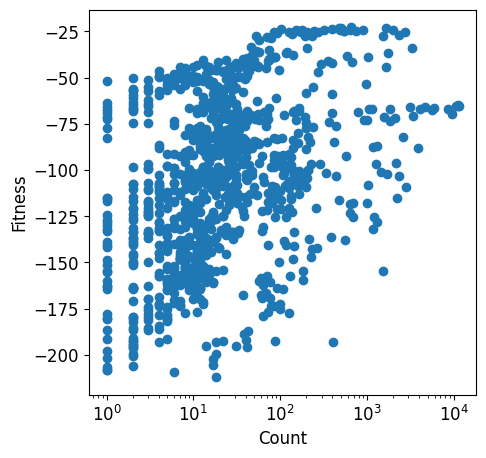

In [63]:
is_empty = repertoire.fitnesses == -jnp.inf
# counts
counts = repertoire.count[~is_empty]
# fitnesses
fitnesses = repertoire.fitnesses[~is_empty]

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(counts, fitnesses)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("Fitness")

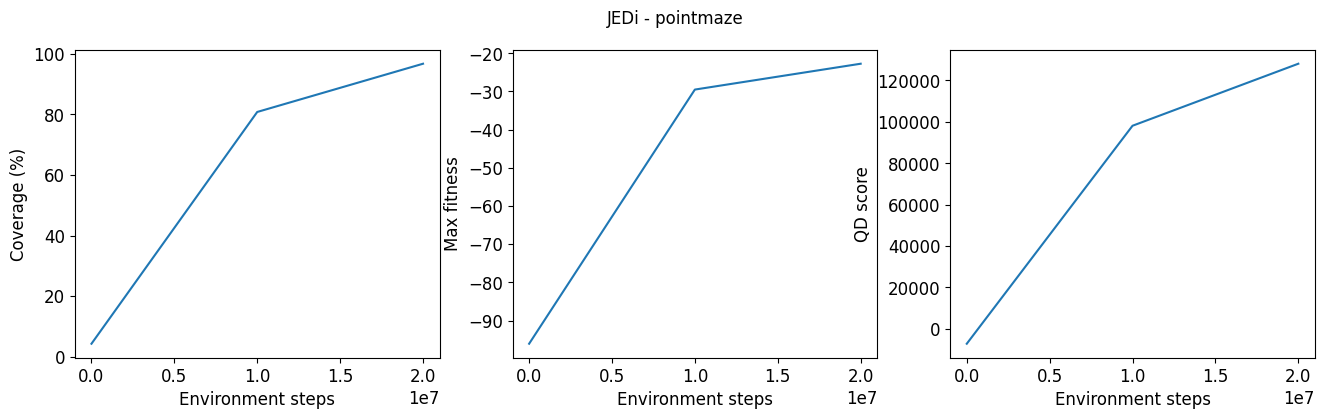

In [62]:
import matplotlib.pyplot as plt
# Plot results
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
x_axis = 'frames'
x_label = 'Environment steps'
plt.suptitle(f"JEDi - {env_name}")
ax[0].plot(logs[x_axis], logs["coverage"])
ax[0].set_xlabel(x_label)
ax[0].set_ylabel("Coverage (%)")
ax[1].plot(logs[x_axis], logs["max_fitness"])
ax[1].set_xlabel(x_label)
ax[1].set_ylabel("Max fitness")
ax[2].plot(logs[x_axis], logs["qd_score"])
ax[2].set_xlabel(x_label)
ax[2].set_ylabel("QD score")
plt.show()

In [ ]:
fig.savefig(f"plots/JEDi_{env_name}_{episode_length}_{num_centroids}.png", dpi=300, bbox_inches="tight")

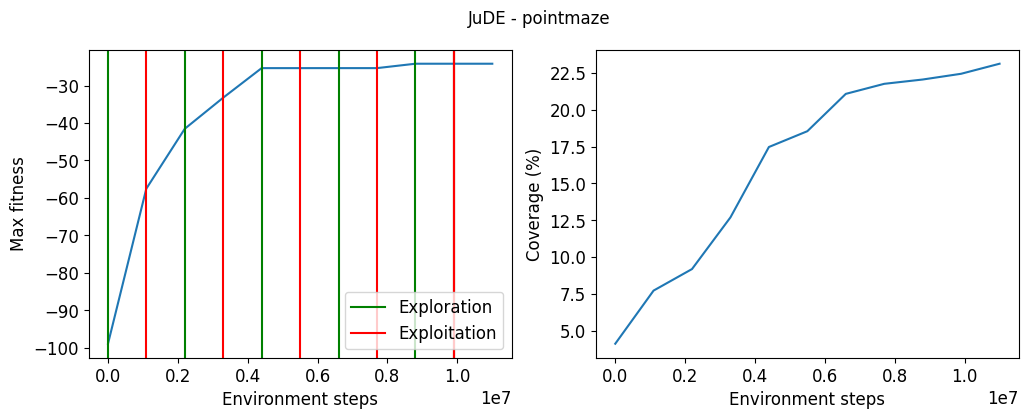

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x_axis = 'frames'
x_label = 'Environment steps'
plt.suptitle(f"JuDE - {env_name}")
ax[0].plot(logs[x_axis], logs["max_fitness"])
ax[0].set_xlabel(x_label)
ax[0].set_ylabel("Max fitness")
ax[1].plot(logs[x_axis], logs["coverage"])
ax[1].set_xlabel(x_label)
ax[1].set_ylabel("Coverage (%)")
for i, x in enumerate(logs[x_axis][:-1]):
    if i%2:
        # Red vertical line
        ax[0].axvline(x, c="r")
    else:
        # green vertical line
        ax[0].axvline(x, c="g")
# Add legend: green = explore, red = exploit
ax[0].axvline(x, c="g", label="Exploration")
ax[0].axvline(x, c="r", label="Exploitation")
# bottom right
ax[0].legend(loc="lower right")
plt.show()


In [41]:
me_rep = end_repertoire
jude_rep = repertoire

In [45]:
centroids = jude_rep.descriptors.astype(jnp.float32)
# Evaluate GP on all centroids
latent_dist = opt_posterior.predict(centroids, train_data=train_data)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [46]:
is_empty = me_rep.fitnesses == -jnp.inf
gp_fitness = predictive_mean[~is_empty]
me_fitness = me_rep.fitnesses[~is_empty]

Text(0.5, 1.0, 'ME vs GP fitness')

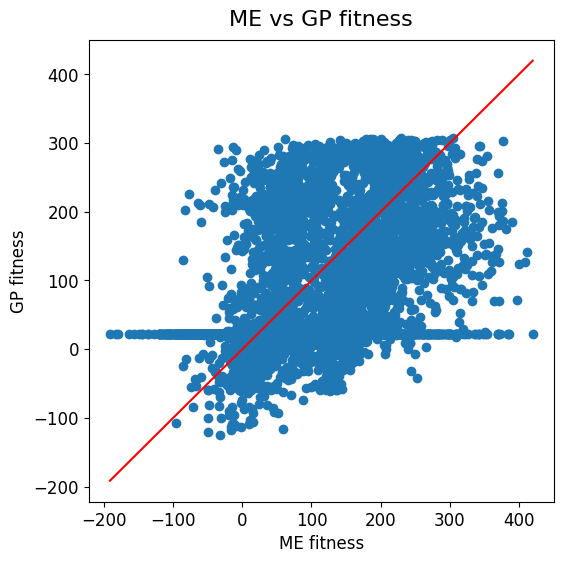

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(me_fitness, gp_fitness)
plt.xlabel("ME fitness")
plt.ylabel("GP fitness")
# plot y=x
x = jnp.linspace(jnp.min(me_fitness), jnp.max(me_fitness), 100)
plt.plot(x, x, c="r")
plt.title("ME vs GP fitness")

In [57]:
me_fitness

Array(-inf, dtype=float32)

Text(0.5, 1.0, 'ME vs GP fitness')

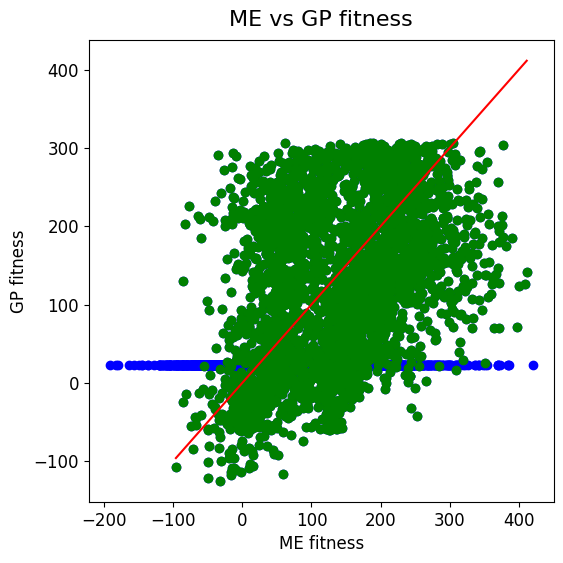

In [62]:
jude_empty = jude_rep.fitnesses == -jnp.inf
me_empty = me_rep.fitnesses == -jnp.inf
one_empty = jude_empty | me_empty

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

gp_fitness = predictive_mean[~me_empty]
me_fitness = me_rep.fitnesses[~me_empty]
ax.scatter(me_fitness, gp_fitness, c="b", label="ME")

gp_fitness = predictive_mean[~one_empty]
me_fitness = me_rep.fitnesses[~one_empty]
ax.scatter(me_fitness, gp_fitness, c="g", label="Both")

ax.set_xlabel("ME fitness")
ax.set_ylabel("GP fitness")
# plot y=x
x = jnp.linspace(jnp.min(me_fitness), jnp.max(me_fitness), 100)
ax.plot(x, x, c="r")
ax.set_title("ME vs GP fitness")

<Axes: >

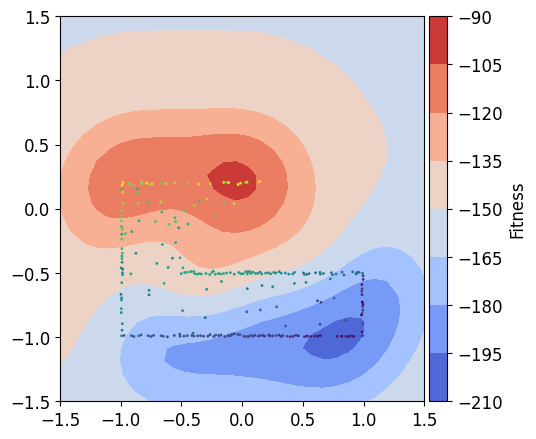

In [31]:
plot_GP(repertoire, opt_posterior, grid_size=30)

In [54]:
wall_width

(0.75, 0.75)